# MMA 865, Individual Assignment 1

Last Updated December 11, 2023.

- [Shouqi, Guo]
- [20441354]
- [08/27/2024]

# Part 1: Sentiment Analysis via the ML-based approach

Download the “Product Sentiment” dataset from the course portal: sentiment_train.csv and sentiment_test.csv.

### Part 1.a. Loading and Prep

Load, clean, and preprocess the data as you find necessary.

In [1]:
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

df_train = pd.read_csv("sentiment_train.csv")

print(df_train.info())
print(df_train.head())

df_test = pd.read_csv("sentiment_test.csv")

print(df_test.info())
print(df_test.head())

# TODO

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2400 non-null   object
 1   Polarity  2400 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.6+ KB
None
                                            Sentence  Polarity
0                           Wow... Loved this place.         1
1                                 Crust is not good.         0
2          Not tasty and the texture was just nasty.         0
3  Stopped by during the late May bank holiday of...         1
4  The selection on the menu was great and so wer...         1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  600 non-null    object
 1   Polarity  600 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.5+ KB
No

### Part 1.b. Modeling

Use your favorite ML algorithm to train a classification model.  Don’t forget everything that we’ve learned in our ML course: hyperparameter tuning, cross validation, handling imbalanced data, etc. Make reasonable decisions and try to create the best-performing classifier that you can.

In [2]:
# Check Null Values
print(df_train.isnull().sum())
print(df_test.isnull().sum())

Sentence    0
Polarity    0
dtype: int64
Sentence    0
Polarity    0
dtype: int64


In [3]:
# Clean up Data
df_train = df_train[~df_train['Sentence'].str.contains('#NAME?') & (df_train['Sentence'].str.len() >= 10)]
df_test = df_test[~df_test['Sentence'].str.contains('#NAME?') & (df_test['Sentence'].str.len() >= 10)]

In [4]:
# Check shape
print(df_train.shape)
print(df_test.shape)

(2393, 2)
(598, 2)


<Axes: xlabel='Polarity'>

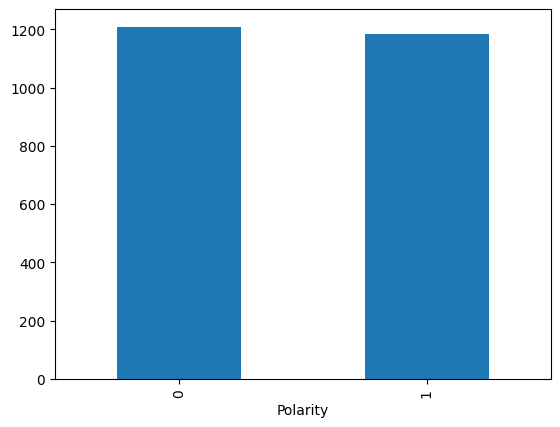

In [5]:
# Check Polarity Distribution
df_train['Polarity'].value_counts().plot.bar()

In [6]:
# Separate features and target label
X = df_train.drop(columns=['Polarity'],axis=1)
y = df_train['Polarity']

In [7]:
# Set up the text preprocessor for the 'Sentence' column
text_preprocessor = Pipeline([
    ('vectorizer', CountVectorizer())
])

# Redefine the preprocessor to include the 'Sentence' column processing
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_preprocessor, 'Sentence')
    ])

# Create a pipeline for the model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('classifier', LogisticRegression(max_iter=100))])

In [8]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('vectorizer',
                                                                   CountVectorizer())]),
                                                  'Sentence')])),
                ('classifier', LogisticRegression())])

In [9]:
# Perform K-Fold Cross-Validation
cv_scores = cross_val_score(pipeline, X, y, cv=20, scoring='accuracy')

In [10]:
# Display cross-validation results
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores):.4f}")

Cross-Validation Accuracy Scores: [0.78333333 0.80833333 0.85833333 0.83333333 0.83333333 0.89166667
 0.81666667 0.9        0.84166667 0.875      0.9        0.83333333
 0.85       0.78991597 0.84033613 0.8487395  0.76470588 0.69747899
 0.73109244 0.79831933]
Mean Cross-Validation Accuracy: 0.8248


### Part 1.c. Assessing

Use the testing data to measure the accuracy and F1-score of your model.  

In [11]:
# Fit the pipeline on the entire training dataset
pipeline.fit(X, y)

# Separate features and target label in the test dataset
X_test = df_test.drop(columns=['Polarity'], axis=1)
y_test = df_test['Polarity']

# Use the trained pipeline to predict on the test set
y_pred_test = pipeline.predict(X_test)

# Calculate the accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy on the test set: {test_accuracy:.4f}")

# Calculate the F1-score on the test set
test_f1_score = f1_score(y_test, y_pred_test)
print(f"F1-Score on the test set: {test_f1_score:.4f}")


Accuracy on the test set: 0.7575
F1-Score on the test set: 0.7513


### Part 2. Given the accuracy and F1-score of your model, are you satisfied with the results, from a business point of view? Explain.

In [12]:
# Considering to merge train and test data to increase the training dataset
# Merge Datasets since they follow the same structure
merged_df = pd.concat([df_train, df_train], ignore_index=True)
print(merged_df.shape)

# Separate features and target label
X2 = merged_df.drop(columns=['Polarity'],axis=1)
y2 = merged_df['Polarity']

# Stratified train-test split
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, stratify=y2, random_state=42
)

# Train the pipeline
pipeline.fit(X2_train, y2_train)

# Predict on the validation set
y2_pred_test = pipeline.predict(X2_test)

# Calculate and print the accuracy on the validation set
accuracy = accuracy_score(y2_test, y2_pred_test)
print(f"Accuracy on the validation set: {accuracy:.4f}")

cm = confusion_matrix(y2_test, y2_pred_test)
print("Confusion Matrix:")
print(cm)

(4786, 2)
Accuracy on the validation set: 0.9478
Confusion Matrix:
[[461  23]
 [ 27 447]]


No. I'm not satisfied with the result. This means that approximately 75.75% of the predictions made by the model on the test set are correct. As the training dataset is small, the model might not have enough data to learn the underlying patterns effectively. 

When combineing the training and testing dataset, we can get a larger dataset to work with. With 80/20 train test split, we are able to increase the accuracy of the dataset to 0.9478. 

### Part 3. Show five example instances in which your model’s predictions were incorrect. Describe why you think the model was wrong. Don’t just guess: dig deep to figure out the root cause.

In [13]:
df_test['Predicted_Polarity'] = y_pred_test
df_test.head()

,Sentence,Polarity,Predicted_Polarity
0,A good commentary of today's love and undoubte...,1,1
1,For people who are first timers in film making...,1,1
2,"It was very popular when I was in the cinema, ...",1,1
3,It's a feel-good film and that's how I felt wh...,1,1
4,It has northern humour and positive about the ...,1,1


In [14]:
df_test[df_test['Polarity']!=df_test['Predicted_Polarity']].head()

,Sentence,Polarity,Predicted_Polarity
8,It really created a unique feeling though.,1,0
12,Not too screamy not to masculine but just righ...,1,0
13,The camera really likes her in this movie.,1,0
14,I would have casted her in that role after rea...,1,0
36,"The soundtrack wasn't terrible, either.",1,0


1. CountVectorizer operates on a bag-of-words approach, which means it treats each word independently without considering the context or the order of words in a sentence. This can lead to misinterpretation, especially in sentences where the sentiment is conveyed through nuance or word combinations. In the sentence "The soundtrack wasn't terrible, either," the word "terrible" might be recognized as negative, but the phrase "wasn't terrible" actually conveys a positive sentiment. The model might not capture the negation ("wasn't") effectively.

2. Sentences that involve sarcasm, irony, or subtle language might be difficult for the model to interpret correctly because these nuances are hard to capture with a simple word count. "It really created a unique feeling though." This sentence might be subtly positive, but without understanding the full context or the tone, the model could interpret "unique" or "though" as indicators of a neutral or even negative sentiment.

3. If certain words or phrases in the test sentences were not present in the training data, the model may not have learned how to associate them with the correct sentiment. The words or phrases "not too screamy" or "casted her" might not have been frequent enough in the training data, leading the model to make incorrect predictions.

4. CountVectorizer does not consider multi-word expressions (MWEs) or n-grams beyond what it’s been set to consider. Some phrases require understanding word combinations rather than individual words to get the correct sentiment. "Not too screamy not to masculine but just right" might have been misinterpreted because the model could have ignored the important structure of "not too X, not too Y, but just right."

5. The model might overly rely on certain words that appear frequently in positive or negative contexts during training, leading to biased predictions. Words like "camera" or "soundtrack" might be associated with neutral or slightly negative sentiments in the training data, leading to incorrect predictions even when the overall sentence is positive.